In [1]:
import cv2
import numpy as np
import os
from scipy.interpolate import interp1d
from pyefd import elliptic_fourier_descriptors
import matplotlib.pyplot as plt
import statistics

In [2]:
%matplotlib inline

In [4]:
# All Requirdef read_images_and_extract_contours_single_image(img_location):

def read_image_and_extract_contour(img_location):
    """Read an image from a given path and extract its largest external contour."""

    image = cv2.imread(img_location)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if contours:
        # Find the largest contour
        contour = max(contours, key=cv2.contourArea)
        contour = contour.squeeze()  # Remove unnecessary dimensions
        return normalize_contour_points(contour)
    else:
        return None  # Return None if no contours are found

def normalize_contour_points(contour):
    """Normalize contour points to a fixed number for consistency."""
    N = 250
    contour_length = np.linspace(0, 1, len(contour))
    normalized_length = np.linspace(0, 1, N)
    interp_func_x = interp1d(contour_length, contour[:, 0], kind='linear')
    interp_func_y = interp1d(contour_length, contour[:, 1], kind='linear')
    normalized_contour = np.vstack((interp_func_x(normalized_length), interp_func_y(normalized_length))).T
    return normalized_contour

def compute_first_10_harmonics(contour, order=30):
    """Compute Fourier coefficients and return the first 10 harmonics."""
    coeffs = elliptic_fourier_descriptors(contour, order=order, normalize=True)
    first_10_harmonics = coeffs[:10]  # Extract the first 10 harmonics
    return first_10_harmonics

def show_image(image_path):
    """Display an image."""
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error loading image: {image_path}")
    else:
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(rgb_image)
    plt.title(image_path)
    plt.axis('off')
    plt.show()


def plot_harmonic_distribution(harmonics):
    """Plot the distribution of the first 10 harmonic or coefficients as magnitudes."""
    # Compute magnitudes for each harmonic (A_n, B_n, C_n, D_n)
    magnitudes = np.linalg.norm(harmonics, axis=1)  # Calculate sqrt(A_n^2 + B_n^2 + C_n^2 + D_n^2)
    
    # Create a plot
    plt.figure(figsize=(8, 5))
    harmonic_indices = np.arange(1, len(magnitudes) + 1)
    plt.bar(harmonic_indices, magnitudes, color='skyblue', alpha=0.7)

    # Add labels and title
    plt.xlabel('Harmonic Number')
    plt.ylabel('Magnitude')
    plt.title('Distribution of the First 10 Harmonics')
    plt.xticks(harmonic_indices)

    # Show the plot
    plt.show()


def compute_S_only_positive(harmonics, m, epsilon=1e-10):
    """
    Compute the separator S by multiplying the magnitude of each harmonic by h^m 
    and summing the values over the first 10 harmonics.
    
    harmonics: array of Fourier coefficients (first 10 harmonics), 
               where each harmonic has 4 components (A, B, C, D).
    m: the power to which the harmonic index h is raised (e.g., 1, 2, or 3).
    epsilon: a small constant to ensure positive magnitudes (default: 1e-10).
    
    Returns a single scalar value for S.
    """
    S = 0
    for h in range(1, 11):  # Loop over the first 10 harmonics (h starts from 1 to 10)
        # Get the Fourier coefficients (A, B, C, D) for the h-th harmonic
        A, B, C, D = harmonics[h - 1]
        
        
        # Compute the magnitude of the harmonic, ensuring it's positive
        magnitude = np.sqrt(A**2 + B**2 + C**2 + D**2)
        
        # Ensure the magnitude is positive by adding a small epsilon if needed
        magnitude = np.abs(magnitude) + epsilon
        
        # Compute the contribution to S (magnitude * h^m)
        S += magnitude * (h ** m)
        
    return S

def calculate_separator_suggested_change(efd_coeffs, m=3):
    # Extract the first 10 harmonics (assuming 4 coefficients per harmonic)
    first_10_harmonics = efd_coeffs[:10]

    # Calculate magnitudes for each harmonic (A, B, C, D)
    magnitudes = np.sqrt(np.sum(np.square(first_10_harmonics), axis=1))  # Compute magnitude for each harmonic

    # Generate harmonic indices, starting from 1 to 10
    harmonic_indices = np.arange(1, 11)

    # Calculate the separator value (sum of weighted magnitudes)
    separator_value = np.sum(magnitudes * np.power(harmonic_indices, m))

    return separator_value


In [5]:
# This Cell section just visualizes the extracted contours

def read_image_and_visualize_contour(img_location):
    """Read an image from a given path and extract its largest external contour."""

    image = cv2.imread(img_location)
    contours_list = []
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if contours:
        # Find the largest contour
        contour = max(contours, key=cv2.contourArea)
        contour = contour.squeeze()  # Remove unnecessary dimensions

        # Normalize the contour points
        normalized_contour = normalize_contour_points(contour)

        # Append the normalized contour to the list
        contours_list.append(normalized_contour)

        # Visualize the contour on the original image
        visualize_contour(image, normalized_contour)

    return contours_list

def visualize_contour(image, contour):
    """Visualize the contour on the image using matplotlib."""
    # Convert image from BGR to RGB for matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image
    plt.imshow(image_rgb)
    
    # Plot the contour on the image
    plt.plot(contour[:, 0], contour[:, 1], color='red', linewidth=2)  # Red contour line
    
    plt.title("Extracted Contour")
    plt.axis('off')  # Hide axes
    plt.show()

def normalize_contour_points(contour):
    """Normalize contour points for visualization (optional)."""
    # This function could be useful for contour normalization
    # Example: Scaling or translating points to some standard size
    return contour

In [11]:
# Initialize lists to store separator values
separator_values_compute_s = []
separator_values_suggested_change = []

In [7]:
# Read in all images of a folder and visualize accordingly

def process_images_in_folder(folder_path):
    """Process all images in a given folder, extract contours, compute harmonics, and calculate separator values."""
    for filename in os.listdir(folder_path):
        if filename.endswith(".png") or filename.endswith(".jpg"):  # Add more image formats if needed
            img_location = os.path.join(folder_path, filename)
            print(f"Processing image: {img_location}")

            # Read image and extract contour
            contour = read_image_and_extract_contour(img_location)

            if contour is not None:
                # Visualize the contour
                read_image_and_visualize_contour(img_location)

                # Compute the first 10 harmonics                
                harmonics = compute_first_10_harmonics(contour)

                # Plot the harmonic distribution
                plot_harmonic_distribution(harmonics)

                # Calculate separator values
                S_compute_s = compute_S_only_positive(harmonics, m=3)
                print(f"S (computed): {S_compute_s}")

                S_suggested_change = calculate_separator_suggested_change(harmonics, m=3)
                print(f"S (suggested change): {S_suggested_change}")

                # Store separator values
                separator_values_compute_s.append(S_compute_s)
                separator_values_suggested_change.append(S_suggested_change)

                # Visualize the contour
                # read_image_and_visualize_contour(img_location)
                print("------------------------------------------------------------")

In [8]:
# Folder path containing images
folder_path = "/home/mishkat/Documents/malformed_potato/5_classes_malformed/heart"  # Change this to your folder path

Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/heart/sd_malformed_12_2_2_428_Potato_2.png


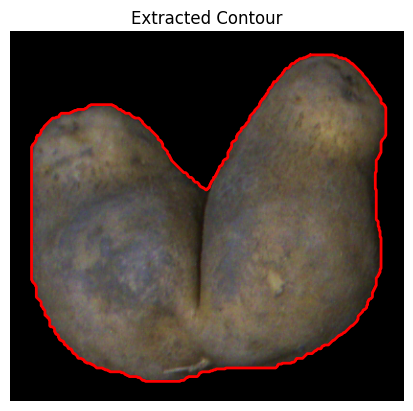

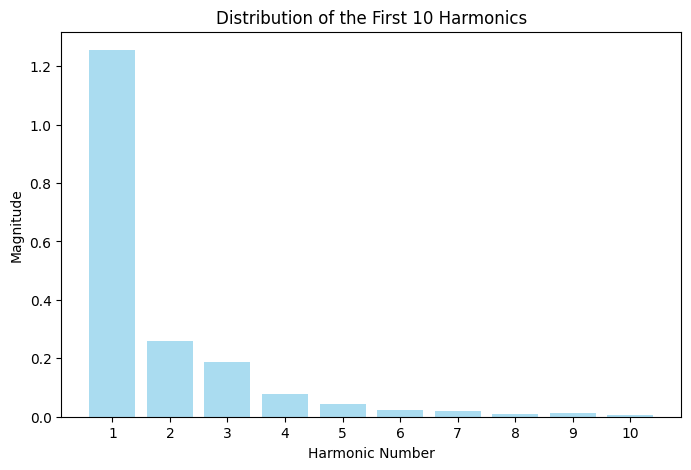

S (computed): 49.88979925684304
S (suggested change): 49.889798954343036
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/heart/sd_malformed_12_2_2_486_8.png


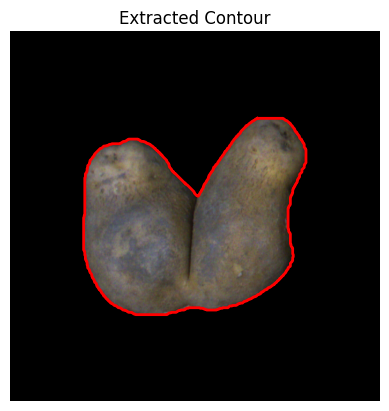

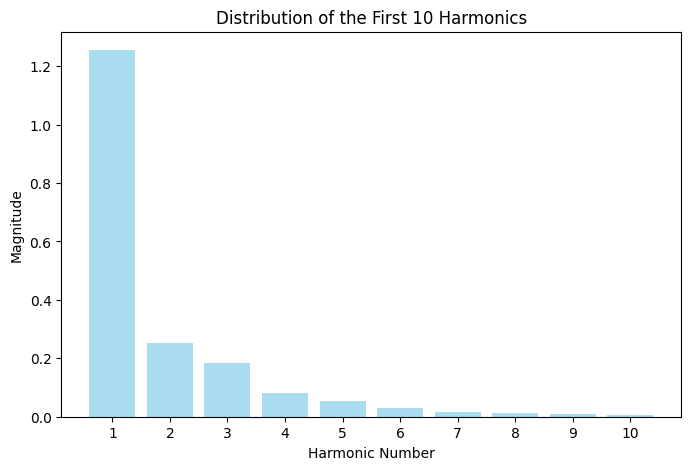

S (computed): 53.38524369046133
S (suggested change): 53.385243387961324
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/heart/sd_malformed_12_2_2_444_2.png


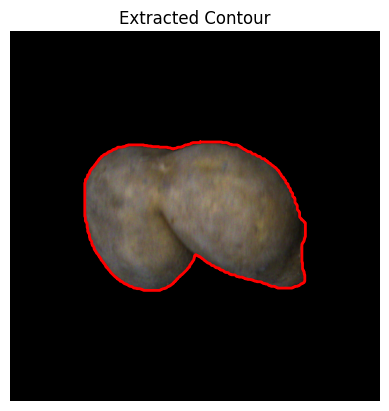

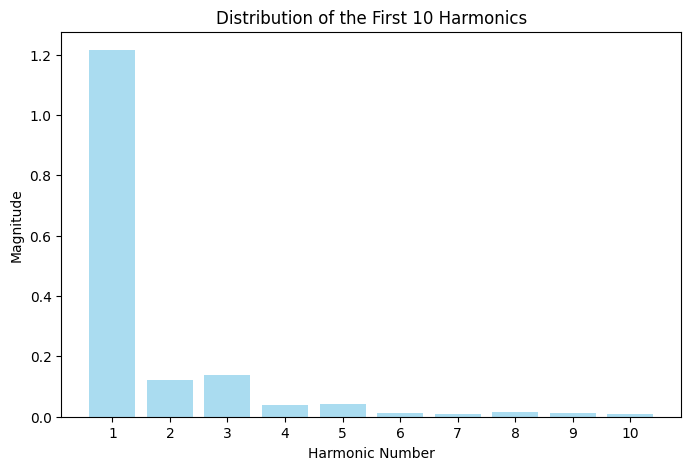

S (computed): 44.427172662899494
S (suggested change): 44.427172360399496
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/heart/sd_malformed_12_2_2_476_9.png


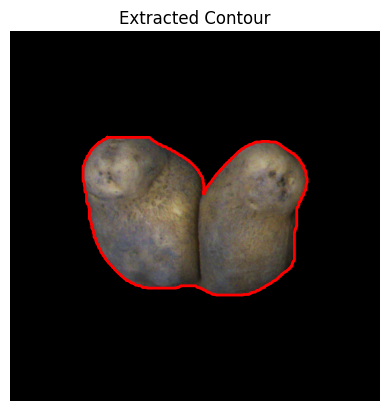

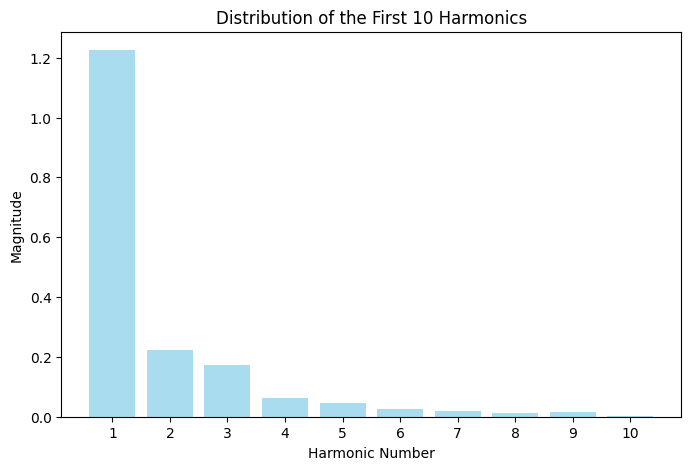

S (computed): 49.52235532800614
S (suggested change): 49.52235502550614
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/heart/sd_malformed_12_2_1_154_0.png


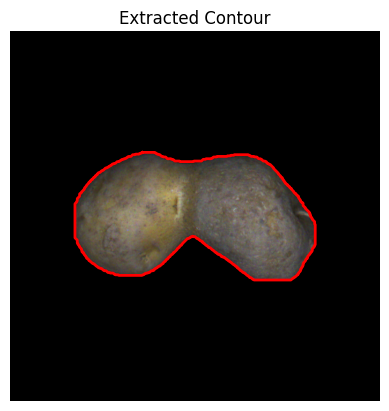

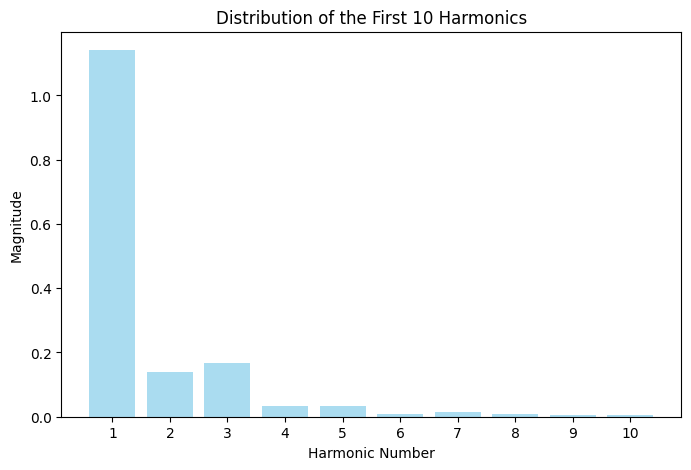

S (computed): 33.75352365487885
S (suggested change): 33.75352335237884
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/heart/sd_malformed_12_2_2_482_10.png


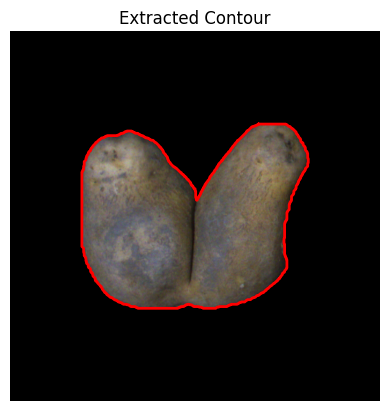

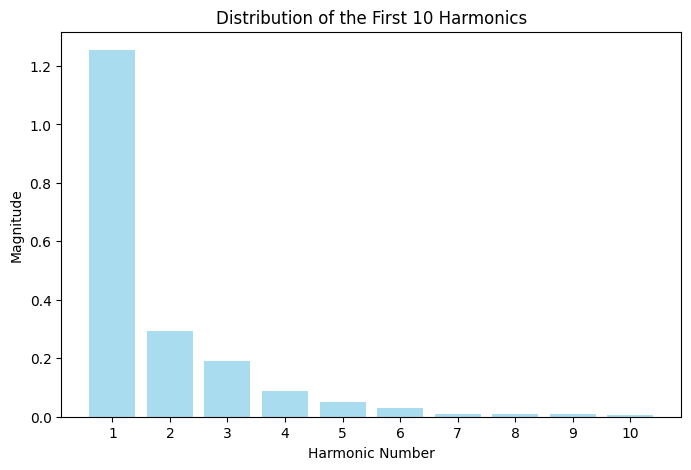

S (computed): 50.25101728785927
S (suggested change): 50.25101698535927
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/heart/sd_malformed_12_2_1_294_10.png


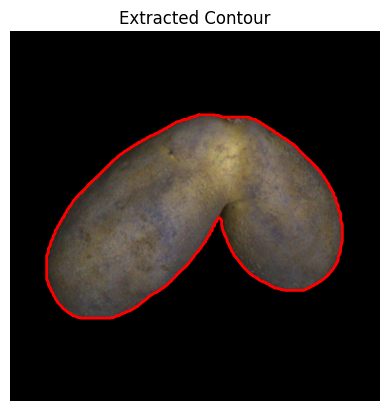

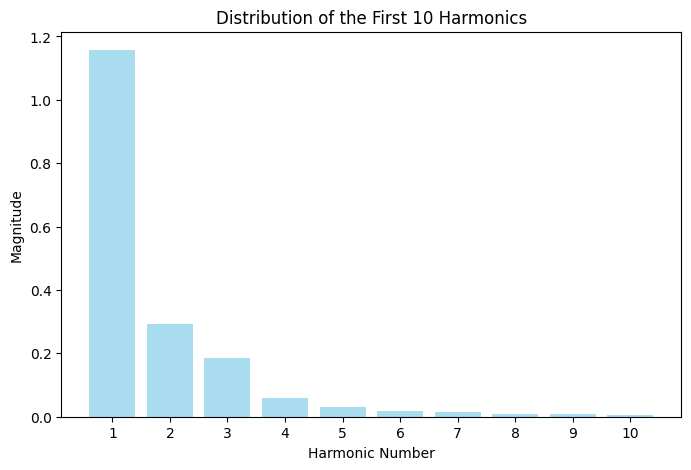

S (computed): 42.658024633897504
S (suggested change): 42.65802433139751
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/heart/sd_malformed_12_2_2_490_10.png


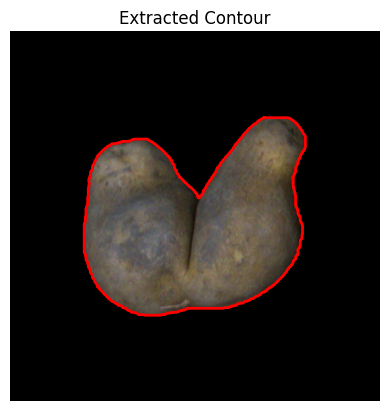

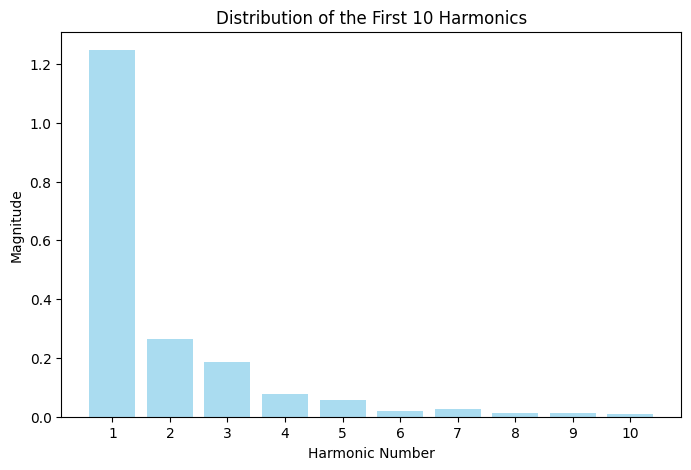

S (computed): 56.39924271569559
S (suggested change): 56.399242413195594
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/heart/sd_malformed_12_2_2_464_11.png


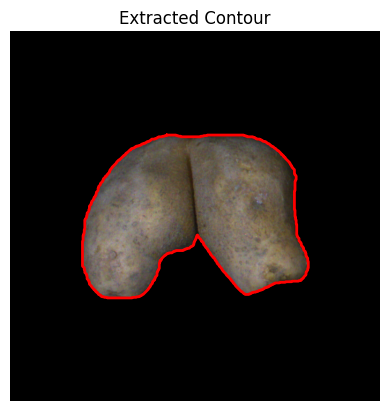

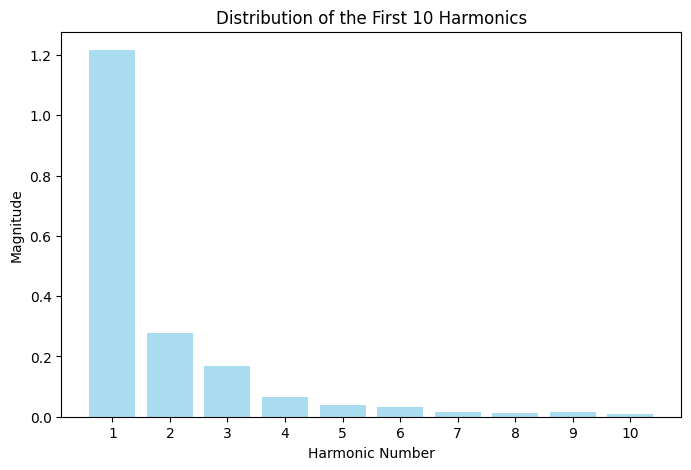

S (computed): 56.444439778194635
S (suggested change): 56.444439475694644
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/heart/sd_malformed_12_2_2_260_8.png


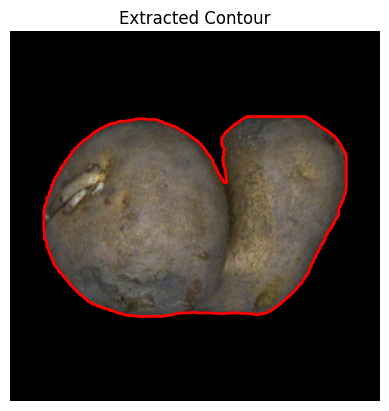

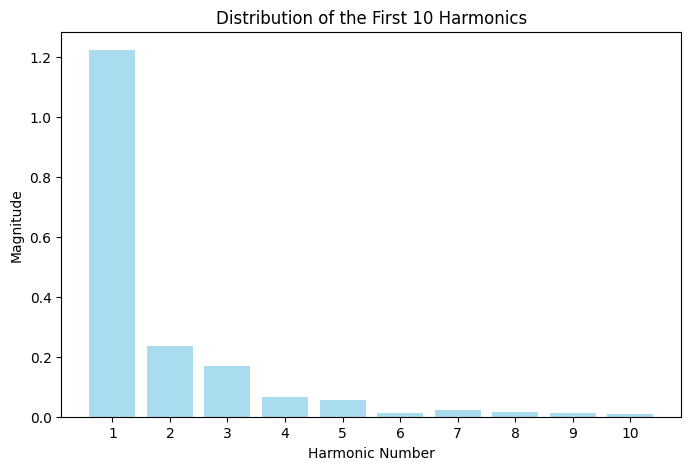

S (computed): 53.548287736357395
S (suggested change): 53.548287433857396
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/heart/sd_malformed_12_2_1_426_1.png


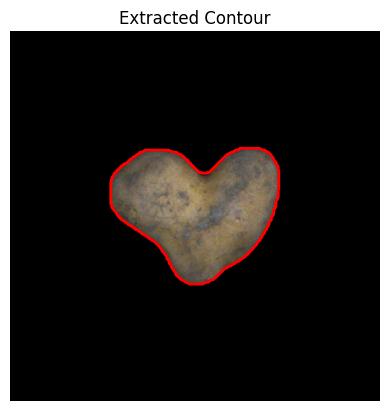

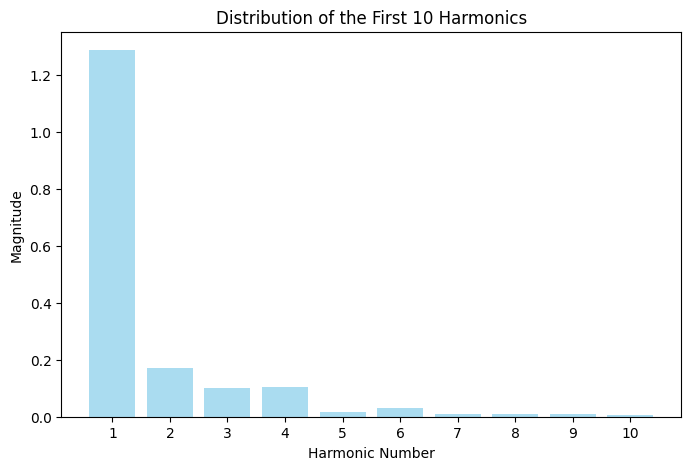

S (computed): 42.478124483179535
S (suggested change): 42.47812418067953
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/heart/sd_malformed_12_2_2_488_5.png


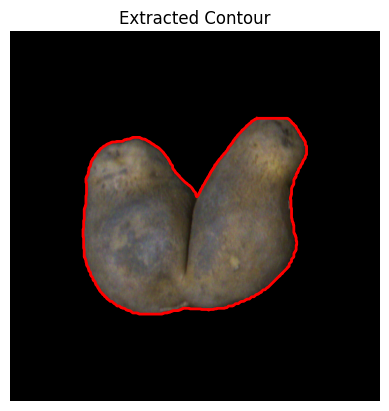

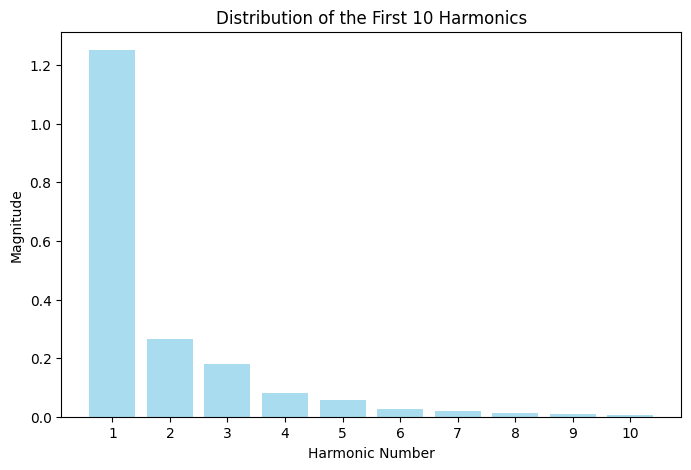

S (computed): 53.28738709913597
S (suggested change): 53.28738679663597
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/heart/sd_malformed_12_2_2_300_8.png


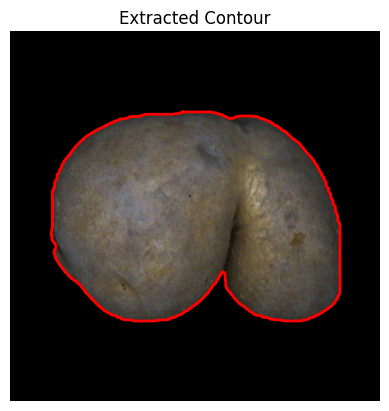

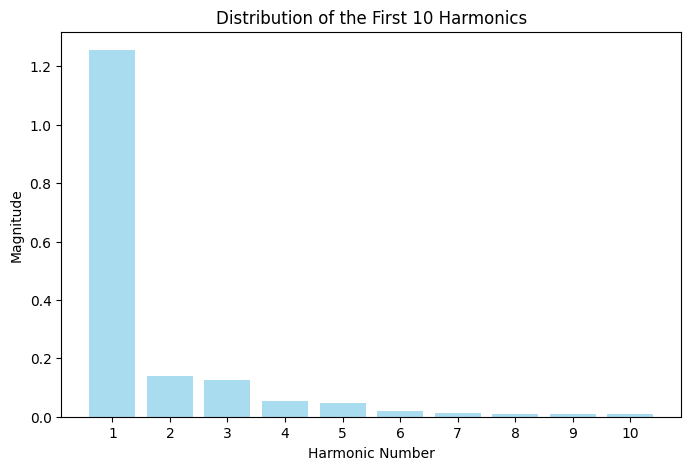

S (computed): 44.516466618607986
S (suggested change): 44.51646631610798
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/heart/sd_malformed_12_2_2_480_15.png


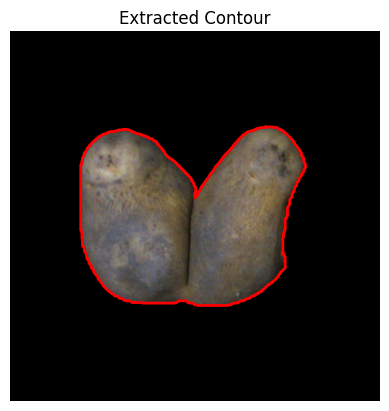

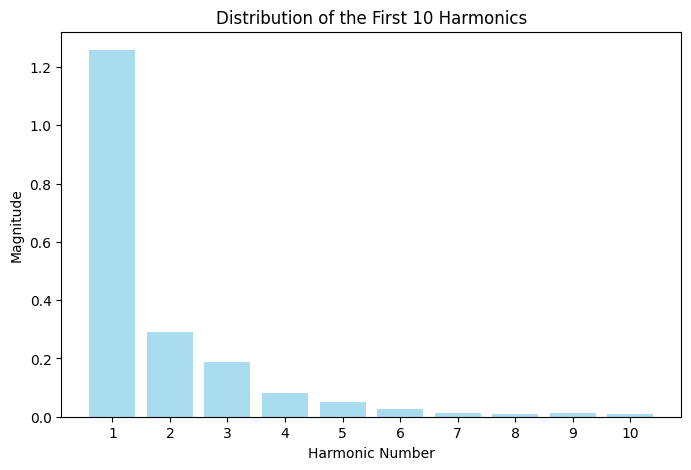

S (computed): 52.48802680518096
S (suggested change): 52.48802650268095
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/heart/sd_malformed_12_2_2_296_2.png


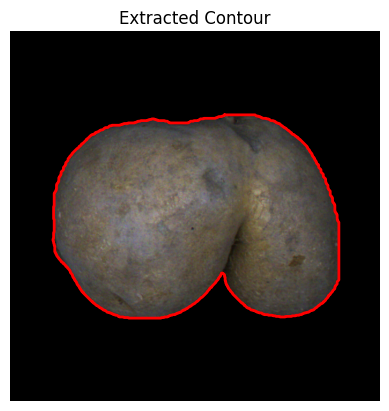

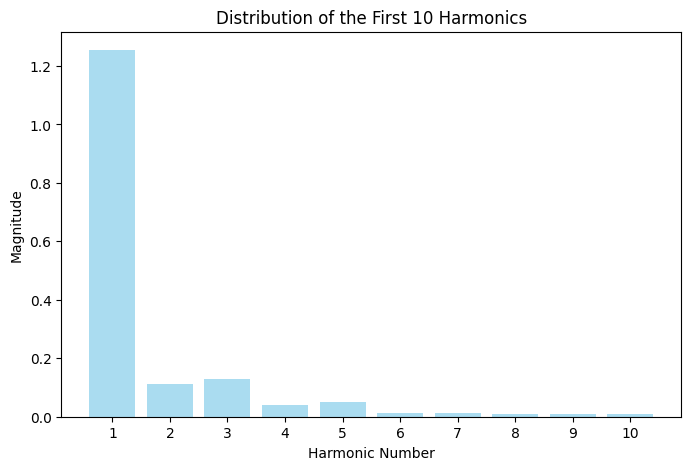

S (computed): 41.87420292708801
S (suggested change): 41.874202624588
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/heart/sd_malformed_12_2_4_188_2.png


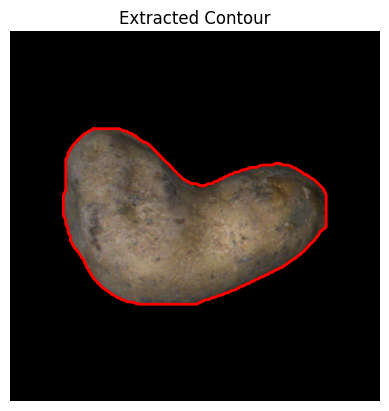

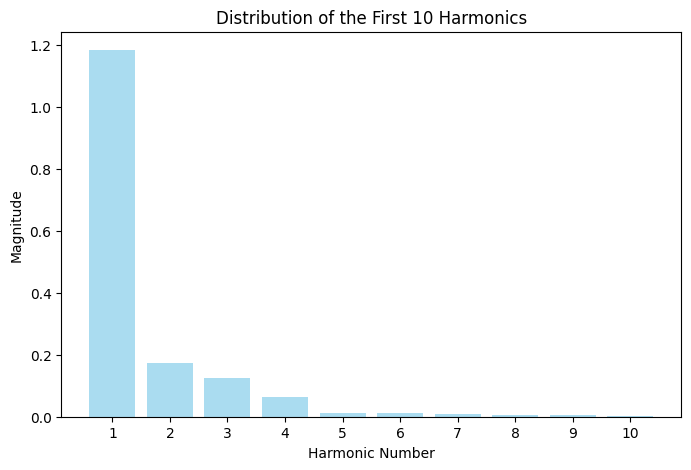

S (computed): 27.223080977574956
S (suggested change): 27.223080675074957
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/heart/sd_malformed_12_2_2_460_9.png


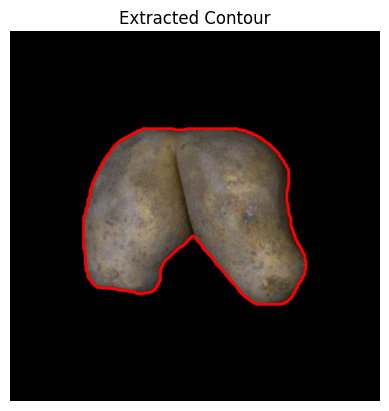

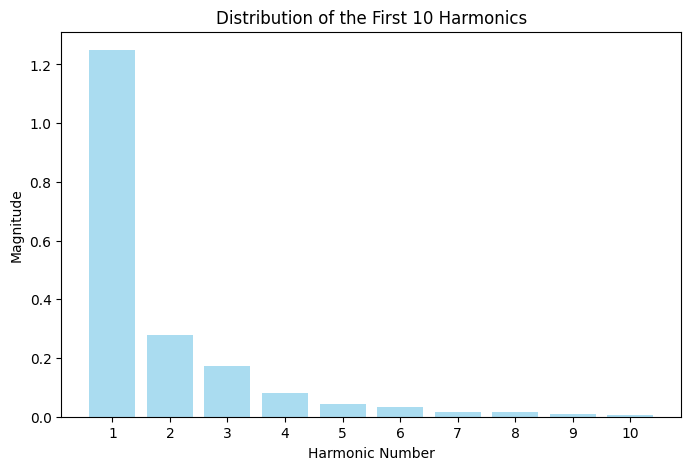

S (computed): 50.725416168808835
S (suggested change): 50.72541586630883
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/heart/sd_malformed_12_2_1_246_11.png


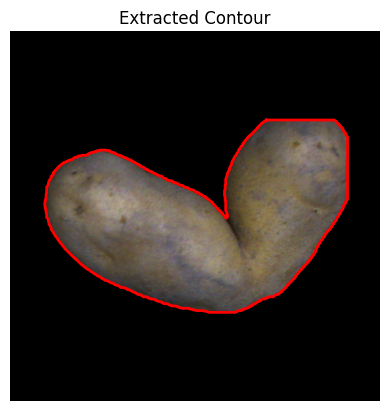

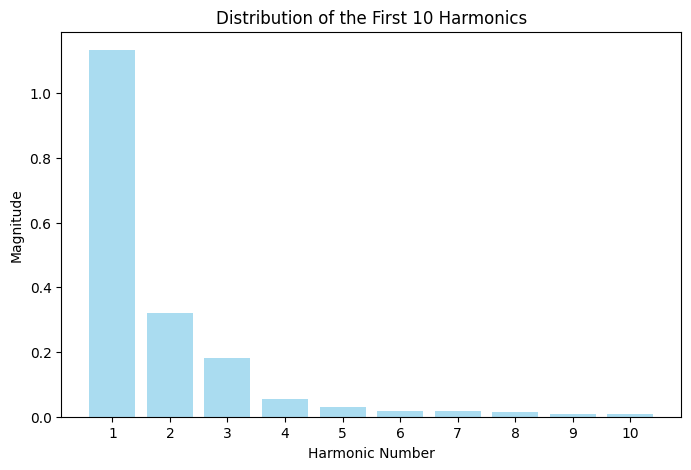

S (computed): 48.11538382168273
S (suggested change): 48.11538351918272
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/heart/sd_malformed_12_2_4_180_2.png


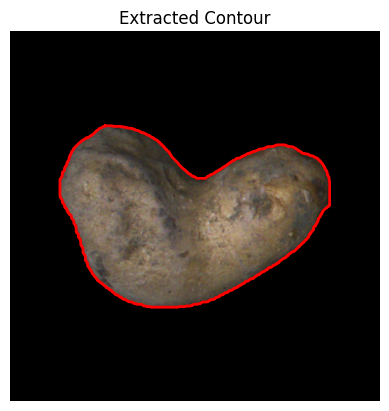

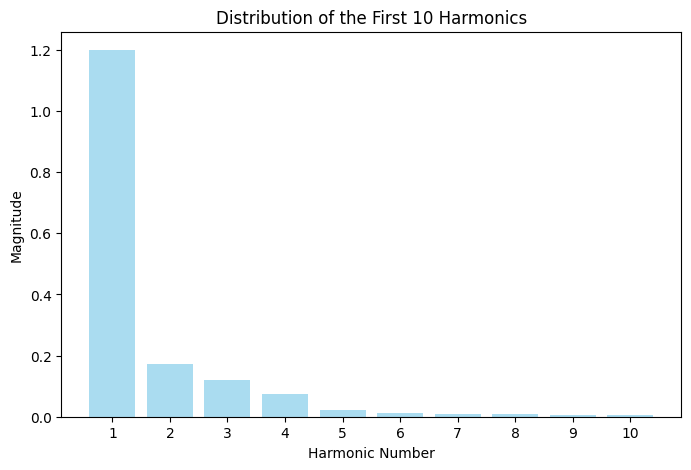

S (computed): 32.19247577738312
S (suggested change): 32.192475474883125
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/heart/sd_malformed_12_2_2_466_12.png


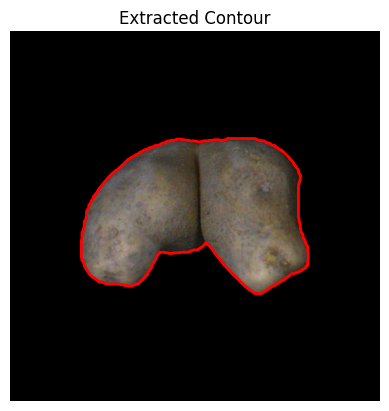

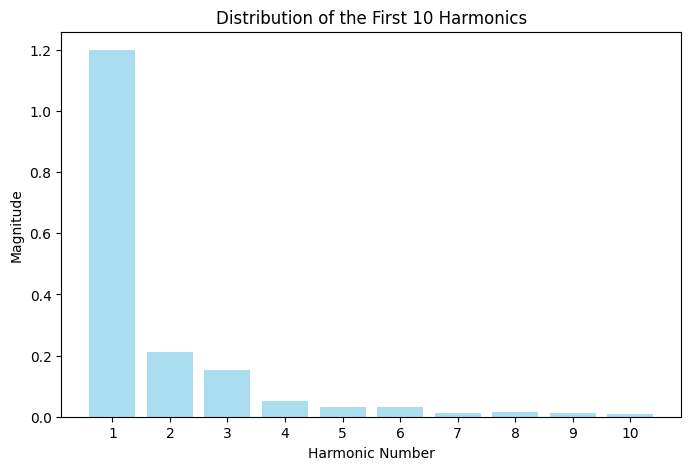

S (computed): 50.60176252780782
S (suggested change): 50.601762225307816
------------------------------------------------------------


In [12]:
# Process images in the specified folder
process_images_in_folder(folder_path)

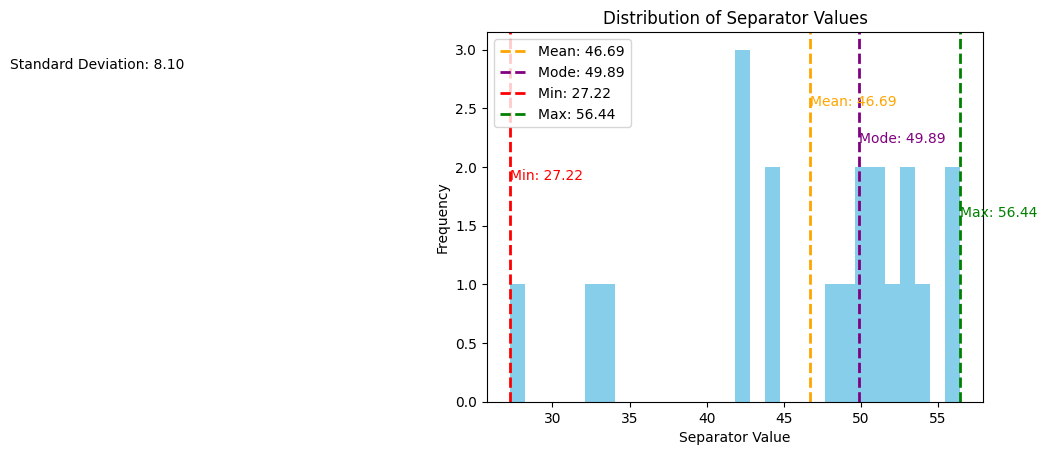

In [13]:
# Assuming separator_values_1 is a list of separator values
plt.hist(separator_values_compute_s, bins=30, color='skyblue')

# Calculate mean, standard deviation, mode, min, and max
mean_value = statistics.mean(separator_values_compute_s)
std_dev = statistics.stdev(separator_values_compute_s)
mode_value = statistics.mode(separator_values_compute_s)
min_value = min(separator_values_compute_s)
max_value = max(separator_values_compute_s)

# Add vertical lines for mean, mode, min, and max
plt.axvline(mean_value, color='orange', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(mode_value, color='purple', linestyle='--', linewidth=2, label=f'Mode: {mode_value:.2f}')
plt.axvline(min_value, color='red', linestyle='--', linewidth=2, label=f'Min: {min_value:.2f}')
plt.axvline(max_value, color='green', linestyle='--', linewidth=2, label=f'Max: {max_value:.2f}')

# Add text annotations for mean, standard deviation, mode, min, and max
plt.text(mean_value, plt.ylim()[1] * 0.8, f'Mean: {mean_value:.2f}', color='orange')
plt.text(mode_value, plt.ylim()[1] * 0.7, f'Mode: {mode_value:.2f}', color='purple')
plt.text(min_value, plt.ylim()[1] * 0.6, f'Min: {min_value:.2f}', color='red')
plt.text(max_value, plt.ylim()[1] * 0.5, f'Max: {max_value:.2f}', color='green')
plt.text(0.5, plt.ylim()[1] * 0.9, f'Standard Deviation: {std_dev:.2f}', ha='center')

# Add labels, title, and legend
plt.xlabel("Separator Value")
plt.ylabel("Frequency")
plt.title("Distribution of Separator Values")
plt.legend()
plt.show()